# Social Graphs Final Project

Analysis of Marvel characters and movies, using the marvel fandom wiki.
https://marvelcinematicuniverse.fandom.com/wiki/Marvel_Cinematic_Universe_Wiki

## Summary

### Motivations
### I. Get the DATA
### II. Basic Stats
### III. Community Detection
### IV. Sentiment Analysis
### V. Discussion
### VI. Contributions

# Motivations

Ever wondered which Marvel character is happiest? or saddest? And how are they related ? Well wait no longer. we found out.

For this project, we wanted to work with data on which we already had some knowledge, in order to be able to argue the results that we obtain from the different analyzes. We then choose to work with a Marvel dataset, containing all the characters and movies of the Marvel Cinematic Universe (so only the movies). This provides a quite high amount of data, with a lot of relations between characters and movies, so we could analyse it many different ways.

We downloaded the wiki pages of every character and every released movie from the marvel fandom wikipedia. Every hyperlink from one character page to another is deemed as a connection between those two. The text describing the character on the fandom page determines their happiness and sadness. Similarly the movie plots from a movie's fandom page determines the happiness of that movie. The relations between characters let us find communities, that we can analyse and compare to the marvel story.

In [3]:
# IMPORTS
import pandas as pd
import numpy as np
import urllib.request
import re
import json
from unidecode import unidecode
import os
import nltk
import string
import matplotlib.pyplot as plt
import scipy, tqdm, Cython
import igraph 
from fa2 import ForceAtlas2
import networkx as nx
from pylab import rcParams
from community import community_louvain

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# I. Get the DATA

## Data cleaning and preprocessing

We found every character names in the marvel wiki fandom, and downloaded their page content. We only saved the character's page when this character actually plays in a marvel movie, to get rid of the tv series characters. For that we used a regex to find the movie section in the page. We also had to remove two characters of the list, whose page content was empty. The same work has been done for the movies.

To analyse the text of characters and movie plots, we had to do more cleaning of the data. For both case we used regex to crop the text, to only keep the relevant parts of it. Then each text went through a cleaning process, in order to be analysed with the LabMT ressource:
- Remove the links and any kind of formating from the wiki
- Tokenize the text into a list of items
- Remove any kind of punctuation
- Lower every letters
- Lemmatize each word
- Only keep words with at least 4 letters (to exclude the most common english words)

Then we can have a clean list with only the words that are relevant for a sentiment analysis. We decided to keep only the characters with a certain amount of words in their biography, so the analysis is more relevant and we don’t focus on the small characters.

In [ ]:
listNames = []
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Find every character in the wiki
for letter in letters:
    urlCharacters = 'https://marvelcinematicuniverse.fandom.com/wiki/Category:Characters?from=' + letter
    response = urllib.request.urlopen(urlCharacters)
    data = response.read()
    pageText = data.decode('utf-8')

    regex = r'class="category-page__member-link" title="(.*?)(?:/.*?)?"'
    names = re.findall(regex, pageText)
    for name in names:
        name = name.replace("&#039;", "'")
        name = name.replace('&quot;', '"')
        if (name.find('Category') == -1) and name not in listNames:
            listNames.append(name)

In [ ]:
print(len(listNames), 'characters found')

2945 characters found


In [ ]:
# Save to text file the content of the character's page, if he plays in at leat one movie
def download_page(name):
    
    # QUERY
    base_url = "https://marvelcinematicuniverse.fandom.com/api.php?"
    action = "action=query"
    dataformat = "format=json"
    content = "prop=revisions&rvprop=content&rvslots=*"
    title =  unidecode(name.replace(' ', '_'))

    query = f"{base_url}{action}&{dataformat}&titles={title}&{content}"

    # DOWNLOAD URL
    response = urllib.request.urlopen(query)

    # TO JSON
    response_json = json.loads(response.read())

    # FILTERING TO INFO
    response_json = response_json["query"]["pages"]
    try:
        character_info = response_json[next(iter(response_json))]["revisions"][0]["slots"]["main"]["*"]
    except:
        print('Error', name)

    # SAVE TO TEXT FILE
    try:
        # Check if the character plays in at leat one movie (to exclude characters from series)
        if (character_info.find('|movie = ') > -1):
            with open("/work/characters/" + title + ".txt", "w", encoding="utf-8") as text_file:
                text_file.write(character_info)
        else:
            pass
    except:
        pass

# biff is empty 
# Kree Warrior is empty 
# User blog: is not a character 
# Señor Scratchy is mistreaded with unidecode
# Vernon Muños is mistreaded with unidecode
#        unidecode('ñ') => n    # mistread 

In [ ]:
os.mkdir('characters')

for name in listNames:
    download_page(name)

Error Kree Warrior
Error User blog:MAYUKH DAS
Error Señor Scratchy
Error Vernon Muñoz


In [ ]:
# Get a list of every movie the character has starred in
def get_movies(character):
    with open("characters/" + unidecode(character.replace(' ', '_')) + ".txt", "r", encoding="utf-8") as text_file:
        content = text_file.read()
        content = content[content.find('|movie = '):]
        content = content[:content.find('\n')]
        movies = content.split('<br>')
        
        regex = r'\'\'\[\[(.*?)(?:\|.*?)?\]\]\'\''

        movie_list = []
        for movie in movies:
            # If the character actually plays in the movie
            if (movie.find('<small>') == -1):
                movie_list.append(re.findall(regex, movie)[0])
        return movie_list  

In [ ]:
movies_for_each_character = {}
characters_with_movies = []
for character in listNames:
    try:
        movies = get_movies(character)
        if movies != []:
            movies_for_each_character[unidecode(character.replace(' ', '_')) ] = movies
            characters_with_movies.append(character)
    except:
        pass 

In [ ]:
#FIND UNIQUE MOVIES FROM THE CHARACTERS
unique_movies = list(sorted({ele for val in movies_for_each_character.values() for ele in val}))

In [ ]:
movie_columns = []
for i in range(1,22): # Top number of movies for a character is 21
    movie_columns.append('Movie'+str(i))


In [ ]:
# CREATE CHARACTER AND THEIR MOVIES CSV
df = pd.DataFrame.from_dict(movies_for_each_character, orient='index', columns= movie_columns) #, columns=['character', 'movies'])
df.to_csv("./marvel_characters_movies.csv", sep=',',index=True)

In [ ]:
# WRITE CSV OF NAMES 
df = pd.DataFrame(data={"Name": characters_with_movies})
#df = pd.DataFrame(data={"Name": listNames})
df.to_csv("./marvel_characters.csv", sep=',',index=False)
print(len(df), " characters")

530  characters


In [ ]:
# GET LIST OF MOVIES FROM FANDOM API 
urlMovies = 'https://marvelcinematicuniverse.fandom.com/wiki/Category:Released_Movies'
response = urllib.request.urlopen(urlMovies)
data = response.read()
pageText = data.decode('utf-8')
pageText


regex = r'\/wiki\/([^"]*)" class="category'
movies = re.findall(regex, pageText)
print("Number of movies : ", len(movies))
movies

Number of movies :  26


['Ant-Man_(film)',
 'Ant-Man_and_the_Wasp',
 'Avengers:_Age_of_Ultron',
 'Avengers:_Endgame',
 'Avengers:_Infinity_War',
 'Black_Panther_(film)',
 'Black_Widow_(film)',
 'Captain_America:_Civil_War',
 'Captain_America:_The_First_Avenger',
 'Captain_America:_The_Winter_Soldier',
 'Captain_Marvel_(film)',
 'Doctor_Strange_(film)',
 'Eternals_(film)',
 'Guardians_of_the_Galaxy_(film)',
 'Guardians_of_the_Galaxy_Vol._2',
 'Iron_Man_(film)',
 'Iron_Man_2',
 'Iron_Man_3',
 'Shang-Chi_and_the_Legend_of_the_Ten_Rings',
 'Spider-Man:_Far_From_Home',
 'Spider-Man:_Homecoming',
 'The_Avengers',
 'The_Incredible_Hulk',
 'Thor_(film)',
 'Thor:_Ragnarok',
 'Thor:_The_Dark_World']

In [ ]:
# Download movie plots

os.mkdir('movie_plots')

# QUERY
base_url = "https://marvelcinematicuniverse.fandom.com/api.php?"
action = "action=query"
dataformat = "format=json"
content = "prop=revisions&rvprop=content&rvslots=*"

for movie in movies:
    title = movie
    query = f"{base_url}{action}&{dataformat}&titles={title}&{content}"

    # DOWNLOAD URL
    response = urllib.request.urlopen(query)

    # TO JSON
    response_json = json.loads(response.read())

    # FILTERING TO INFO
    response_json = response_json["query"]["pages"]
    try:
        movie_info = response_json[next(iter(response_json))]["revisions"][0]["slots"]["main"]["*"]
    except:
        print('Error', movie)
    
    movie_plot = re.findall(r'==Plot==(.*)==Cast==',movie_info,re.DOTALL)
    movie_plot = ''.join(movie_plot)
    movie_plot = re.sub(r'\[\[.*\]\]','',movie_plot)
    
    # TO TXT 
    with open('movie_plots/'+movie+'.txt','w') as f:
        f.write(movie_plot)

# RUN FROM HERE IF YOU DO NOT WISH TO DOWNLOAD DATA

# II. BASIC STATS


OBS: Data cleaning is explained in the I. GET DATA section

The following code will reveal basic stats of the network which is summarized here. By drawing the graph we see a highly connected network with many edges, and a few nodes with less edges on the outer rim of the graph. The network have 3753 edges between 521 nodes. Nodes are of course characters and edges are hyperlinks between character fandom wikipedia pages. The displayed degree distribution shows that the majority of characters has few edges, and few characters (50 or so) have many edges.


In [4]:
csv_path = 'marvel_characters.csv' 
df_marvel_characters = pd.read_csv(csv_path)

In [5]:
# '\[\[(?:.*?#)?(.*?)(?:\|.*?)?(?:\(.*?)?\]\]' 
# ^ Regex to catch hyperlinked characters in a characters description.
pattern1 = '\[\[(?:.*?#)?(.*?)(?:\|.*?)?(?:\(.*?)?\]\]'

In [6]:
# CREATE GRAPH 
Graph_marvel = nx.DiGraph()
pages_path = '/work/characters/'
edge_list = []
for name in df_marvel_characters.Name:
    name = unidecode(name.replace(' ','_'))
    # LOAD CHARACTER PAGES
    try:
        with open(pages_path + name + '.txt', 'r') as f:
            character_description = f.read()
    except:
        print('Could not find page:', name)
    # FIND HYPEERLINKS IN CHARACTER PAGE
    matches = re.findall(pattern1 , character_description)
    for match in matches:
        # IS HYPERLINK A CHARACTER?
        if df_marvel_characters[df_marvel_characters.Name == match].any()[0]:
            match = unidecode(match.replace(' ','_'))
            # ADD EDGE TO DIGRAPH
            Graph_marvel.add_edge(name, match)
            # ADD EDGE TO LIST
            edge_list.append([name, match])

In [7]:
# CREATE PANDAS DATAFRAME FROM LIST 
df_edge_list = pd.DataFrame(edge_list, columns =['From', 'To'])
df_edge_list = df_edge_list.drop_duplicates()
# WRITE CSV OF EDGES
df_edge_list.to_csv("./edge_list.csv", sep=',',index=False)

### DRAW GRAPH

In [8]:
# CREATE GRAPH FROM EDGE LIST  
csv_path = 'edge_list.csv' 
df_edges = pd.read_csv(csv_path)

edges = [tuple(x) for x in df_edges.to_numpy()]

Graph_marvel = nx.DiGraph() #Community detection only works for undirected graphs
#Graph_marvel = nx.Graph()
Graph_marvel.add_edges_from(edges)

In [9]:
# Extract GCC (Giant Connected Component)
# run the cell with graph with characters that appear in movies instead of Graph_marvel 

Graph_marvel_undirected = Graph_marvel.to_undirected()
# Creates list with nodes for each component
compons = []
for i in nx.connected_components(Graph_marvel_undirected):
    compons.append(i)
    
# Finds the position of the component with the max number of nodes which is the GCC
length = []
for i in compons:
    length.append(len(i))
    
    
position_of_GCC = length.index(max(length))

# Extracts GCC
GCC = Graph_marvel_undirected.subgraph(compons[position_of_GCC]).copy() 
GCC_nodes = list(GCC.nodes())

In [10]:
# FORCE ATLAS FOR BEAUTIFUL GRAPHS 
forceatlas2 = ForceAtlas2(
# Behavior alternatives
outboundAttractionDistribution=True,  # Dissuade hubs
linLogMode=False,  # NOT IMPLEMENTED
adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
edgeWeightInfluence=1.0,

# Performance
jitterTolerance=1.0,  # Tolerance
barnesHutOptimize=True,
barnesHutTheta=1.2,
multiThreaded=False,  # NOT IMPLEMENTED

# Tuning
scalingRatio=2.0,
strongGravityMode=False,
gravity=1.0,

# Log
verbose=True)

# CHANGE SIZE OF PLOT 
rcParams['figure.figsize'] = 15,10

100%|██████████| 2000/2000 [00:07<00:00, 262.22it/s]
BarnesHut Approximation  took  2.43  seconds
Repulsion forces  took  4.11  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.18  seconds
AdjustSpeedAndApplyForces step  took  0.31  seconds


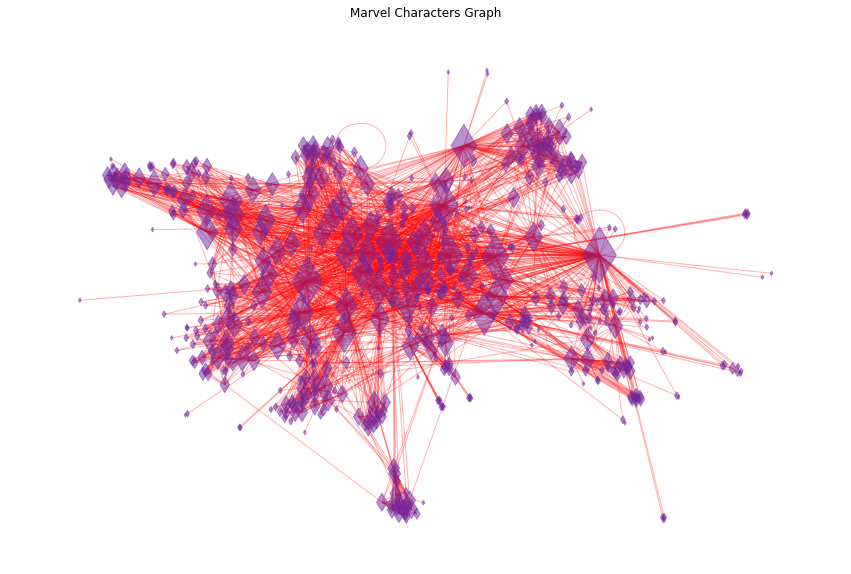

In [11]:
G=GCC

d = dict(GCC.degree)

# PLOT DETAILS
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=[v * 10 for v in d.values()],node_color='#7027A0',node_shape='d', alpha=0.5)
nx.draw_networkx_edges(G, positions,edge_color='red', alpha=0.3)
plt.axis('off')
plt.title("Marvel Characters Graph")

plt.show()

### NUMBER NODES AND EDGES

In [12]:
print('Number of nodes:',len(Graph_marvel.nodes))
print('Number of edges:',len(Graph_marvel.edges))

Number of nodes: 521
Number of edges: 6368


### DEGREE DISTRIBUTION

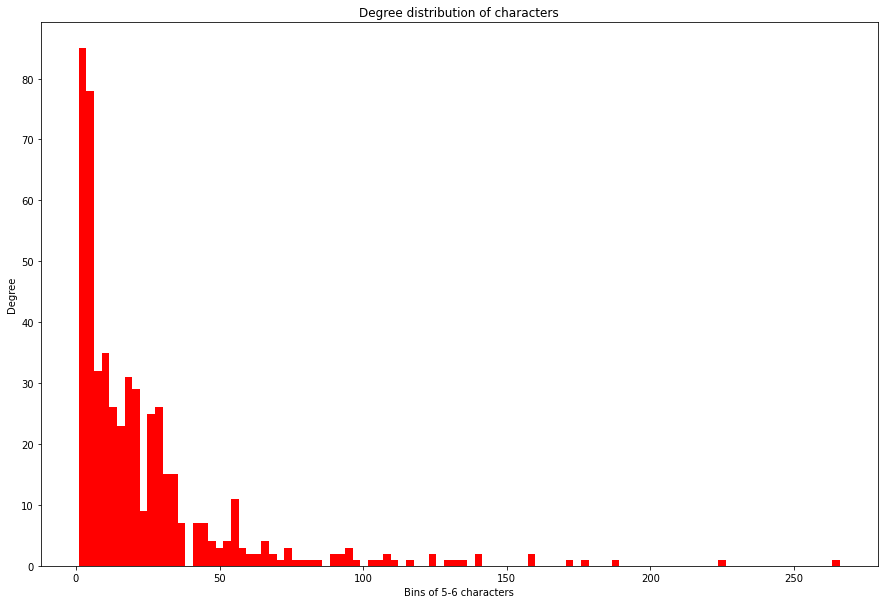

In [13]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins=100, color='red')
    plt.ylabel('Degree')
    plt.xlabel('Bins of 5-6 characters')
    plt.title("Degree distribution of characters")
    plt.show()

plot_degree_dist(Graph_marvel)

# III. Community Detection

In [14]:
# Create graph 
csv_path = 'edge_list.csv' 
df_edges = pd.read_csv(csv_path)

edges = [tuple(x) for x in df_edges.to_numpy()]

#Graph_marvel = nx.DiGraph() #Community detection only works for undirected graphs
Graph_marvel = nx.Graph()
Graph_marvel.add_edges_from(edges)

In [15]:
print("Number of nodes : ", len(Graph_marvel.nodes))

Number of nodes :  521


In [16]:
# WE DO NOT HAVE DUPLICATE EDGES? 
df_edges[df_edges.duplicated(keep=False)]

,From,To


In [17]:
# FIND COMMUNITIES WITH LOUVAIN 
communities = community_louvain.best_partition(Graph_marvel,random_state=1)
# Convert to dataframe to interpret & sort on community size
df_communities = pd.DataFrame.from_dict(communities, orient='index', columns=['community'])
sorted_communities = df_communities['community'].value_counts() 

In [18]:
df_communities.to_csv("community.csv")

In [19]:
# TOP 3 BIGGEST COMMUNITIES 
sorted_communities

9     105
4      74
7      72
8      56
1      55
5      41
10     31
0      28
6      22
3      20
2      17
Name: community, dtype: int64

In [20]:
# Most connected characters
degree_list = []
for character in Graph_marvel.nodes():
    degree_list.append([character, Graph_marvel.degree(character)])

df_degree = pd.DataFrame(degree_list, columns =['Name', 'Degree'])    

In [21]:
# MERGE community and degree 
popular_communities = df_degree.merge(df_communities, left_on=df_degree.Name, right_on=df_communities.index)
popular_communities = popular_communities.drop(['key_0'], axis=1) # DROP DUPLICATE COLUMN 

#### Hypothesis:
We have found 12 communities and we have 10 movies named after a character. Moreover Eternals and Guardians of the Galaxy which we expect to have their own community. 

Will the 10 characters be in different communities found by the Lauvain algorithm and will eternal characters and Guardians of the Galaxy also have their own community? 

In [22]:
# ARE THE CHARACTERS WITH HIGHEST DEGREE THE SAME AS THE 10 MAIN CHARACTERS? 
main_characters = ['Ant-Man', 'Black_Panther', 'Black_Widow', 'Captain_America', 'Captain_Marvel', \
                    'Doctor_Strange', 'Iron_Man', 'Spider-Man', 'Hulk', 'Thor']

print('Number of main characters:', len(main_characters))

for character in main_characters:
    try:
        com = popular_communities[popular_communities.Name == character].community.values[0]
        print(character, com)
    except:
        print('CAN NOT FIND:', character)

Number of main characters: 10
Ant-Man 5
Black_Panther 0
Black_Widow 7
Captain_America 7
Captain_Marvel 2
Doctor_Strange 6
Iron_Man 9
Spider-Man 1
Hulk 4
Thor 4


From the data above we find that Black Panther, Black Widow and Captain America share community, which negates the hypothesis that main characters have their own community. However we do see that 7/10 have their own community.

## New Hypothesis
We think that edges between characters is present when they share a movie. Thus we think that every community can be a collection of the characters taking part in 2 movies. 

In [23]:
csv_path = 'marvel_characters_movies.csv' 
df_character_movies = pd.read_csv(csv_path)

In [24]:
# MERGE WITH popular communities
character_n_movies = popular_communities.merge(df_character_movies, left_on='Name', right_on='Unnamed: 0')
# DROP DUPLICATE ROW WITH CHARACTER NAME
character_n_movies = character_n_movies.drop(['Unnamed: 0'], axis=1) 

In [25]:
# SIDESTEP RESEARCH
# WHO IS THE CHARACTER APEARING IN  21 MOVIES??
# character_n_movies[character_n_movies.Movie21 == 'Captain Marvel (film)']

In [26]:
# CONVERT MOVIE COLUMNS INTO BINARY MOVIE COLUMNS 
max_no_movies = len(character_n_movies.columns)-3 # - 'Name', 'Degree', 'community'
character_movies_binary = pd.get_dummies(character_n_movies["Movie1"])
for i in range(2,max_no_movies): # the maximum number of movies for one character = 21 = Watcher Informant 
    character_movies_binary2 = pd.get_dummies(character_n_movies["Movie"+str(i)])
    character_movies_binary = character_movies_binary.add(character_movies_binary2, fill_value=0)

In [27]:
# MERGE WITH CHARACTER, DEGREE AND COMMUNITY COLUMNS
communities_with_movies = popular_communities.merge(character_movies_binary, left_index=True, right_index=True)

In [28]:
# SUM COMMUNITY APPEARENCES IN MOVIES 
communities_movies_count = communities_with_movies.groupby(['community']).sum()
# REMOVE DEGREE 
communities_movies_count = communities_movies_count.drop(['Degree'], axis=1) 

In [29]:
# ADD COMMUNITY SIZES 
community_sizes = communities_with_movies.groupby('community').count()

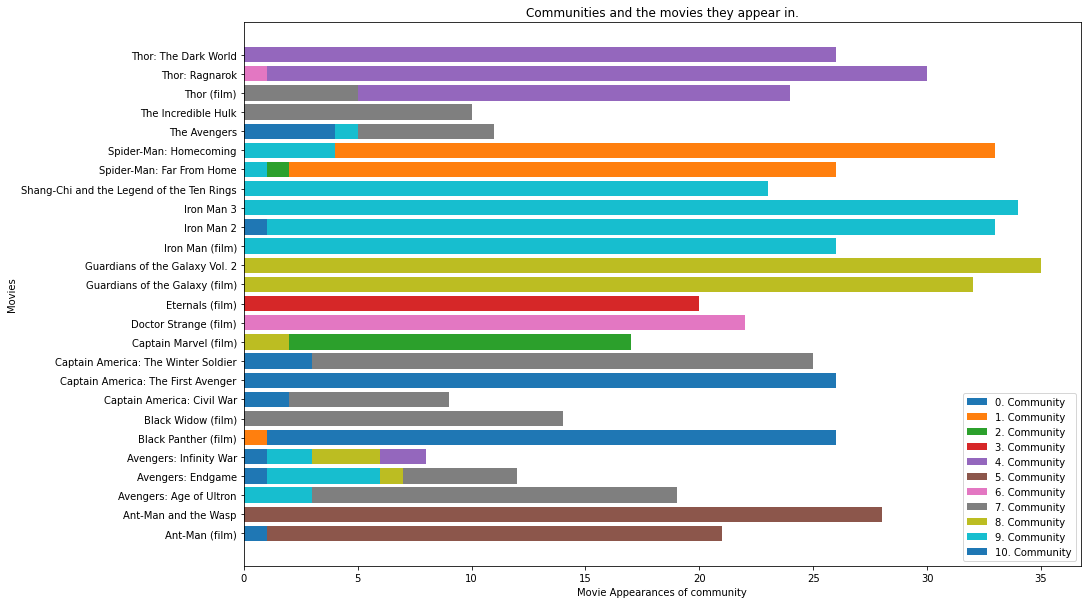

In [30]:
# PLOT MOVIE APPEARENCES OF COMMUNITIES 
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#plt.xticks(rotation=-90)
ax.set_title('Communities and the movies they appear in.')
ax.set_xlabel('Movie Appearances of community')
ax.set_ylabel('Movies')

labels = []
for i in range(0,len(communities_movies_count)): # 11 communities
    ax.barh(communities_movies_count.columns.values, communities_movies_count.iloc[[i]].values[0])
    labels.append(str(i)+'. Community')
ax.legend(labels)
plt.rcParams["figure.figsize"] = (13,13)
plt.show()

#### Hypothesis Approved
The community detection indeed do split communities into characters apearing in the same movies. Hereof most of the characters share 1 movie series i.e. Iron Man series or Captarain America series or a single movie i.e. Eternals or Black Panther. This hypothesis holds for every community except community 0 which is a mix of severel movies and movie series. 

# IV. Sentiment Analysis

## Character sentiment analysis

We calculate here the sentiment score of the marvel characters with the average happiness score of the words in their biography. We decided to keep only the characters with a certain amount of number in their biography, so the analysis is more relevant and we don’t focus on the small characters. We use the LabMT ressource to calculate happiness score of words.

In [31]:
labMT_f =open("LabMT.txt", "r")
labMT = labMT_f.read()

# Get happiness score from a word using LabMT
def get_score(word):
    index = labMT.find('\n' + word + '\t')
    score = 0
    if (index >= 0):
        score = labMT[index:index+50].split('\t')[2] # Add the happiness_average of the found word
    try:
        return float(score)
    except:
        return(-1)

In [32]:
# Clean character text
def clean_content(content):

    # Keep quotes and remove text before the Biography section
    index = content.find("{{Quote|")
    if (index >= 0):
        content = content[index:]
    else:
        index = content.find("==Biography==")
        content = content[index:]

    index = content.find("==Relationships==")
    if (index >= 0):
        content = content[:index]
    else:
        index = content.find("==References==")
        if (index >= 0):
            content = content[:index]
    
    # Remove links and formating
    content = re.sub(r'\[\[.*\]\]','', content)
    content = re.sub(r'<.*>','', content)
    content = re.sub(r'\{\{Quote\|', '', content)
    content = re.sub(r'\|.*\}\}', '', content)

    return content

In [33]:
def get_character_happiness(name):

    with open("characters/" + unidecode(name.replace(' ', '_')) + ".txt", "r", encoding="utf-8") as text_file:
        content = text_file.read()
        
        content = clean_content(content)

        # Tokenize, Remove punctuation and lemmatize
        tokenized = nltk.WordPunctTokenizer.tokenize(nltk.WordPunctTokenizer(), content)
        tokenized = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokenized]
        tokenized = [w.lower() for w in tokenized]
        lemmatized = [nltk.WordNetLemmatizer.lemmatize(nltk.WordNetLemmatizer(), w) for w in tokenized]
        lemmatized = [w for w in lemmatized if len(w) > 3]

        # Calculating score for each word
        # We only keep characters with at least 1000 words with a score, 
        # so the result is more relevent and we focus on the main characters.
        score_list = []

        if(len(lemmatized) >= 1000):
            for word in lemmatized:
                score = get_score(word)
                if (score >= 0):
                    score_list.append(score)
    
        if (len(score_list) >= 1000):
            final_score = sum(score_list)/len(score_list)
        else:
            final_score = 0

    return final_score

In [34]:
happiness_list = pd.DataFrame(columns=['Name', 'Happiness_score'])

# Calculate score for each character
for character in df_marvel_characters.Name:
    score = get_character_happiness(character)
    if (score > 0):
        happiness_list = happiness_list.append({'Name': character, 'Happiness_score': score}, ignore_index=True)

In [35]:
print("Total characters : ", len(happiness_list))

Total characters :  83


In [36]:
print("Saddest characters\n\n", happiness_list.sort_values(by=['Happiness_score'], ascending=[True])[0:10])

Saddest characters

                  Name  Happiness_score
70           Valkyrie         3.736169
44             Nebula         3.780426
63         Taskmaster         3.808675
27               Hela         3.823382
47              Okoye         3.846202
26           Heimdall         3.871532
55  Ronan the Accuser         3.898897
80      Yelena Belova         3.923868
18             Gamora         3.929990
11          Ebony Maw         3.932283


In [37]:
print("Happiest characters\n\n", happiness_list.sort_values(by=['Happiness_score'], ascending=[False])[0:10])

Happiest characters

                Name  Happiness_score
43   Michelle Jones         4.756872
4       Bill Foster         4.636506
58    Sharon Carter         4.609807
2           Ant-Man         4.582862
64    Thaddeus Ross         4.556220
23         Hank Pym         4.535794
45        Ned Leeds         4.528628
7   Captain America         4.528252
29     Howard Stark         4.527376
48     Peggy Carter         4.519075


In [38]:
rcParams['figure.figsize'] = 10,5

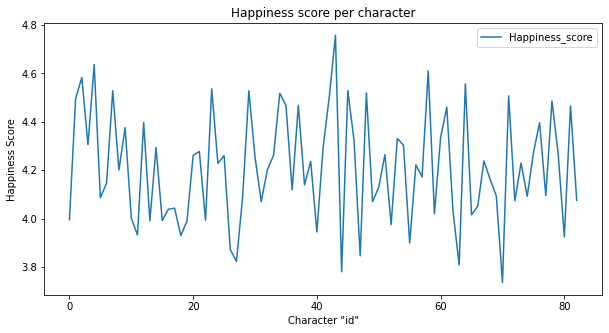

In [39]:
happiness_list.plot()
plt.title('Happiness score per character')
plt.xlabel('Character \"id\"')
plt.ylabel('Happiness Score')
plt.show()

In [40]:
# Save to CSV
happiness_list.to_csv("characters_happiness.csv", sep=';', index=False)

Among the happiest characters, we find 9 “good guys”, and one who can’t be considered as good or bad (Thaddeus Ross). The happiest character of all Marvel is Michelle Jones, a teenager, girlfriend of Spider-Man.

For the saddest characters, we encounter 5 “bad guys”, 4 “good guys” and one  who can’t be considered as good or bad (Yelena Belova). The principal characteristic that they have in common is that they are all great fighter.


## Character sentiment analysis v2

We then thought that a character's happiness and their ability to fight should be calculated separately. For this, we calculated 2 scores for each character. A happiness score, which counts only positive words, and a War score, which counts only negative words, most of which seem related to death and fighting.

In [41]:
def get_character_happiness2(name):

    final_scores = [0,0]

    with open("characters/" + unidecode(name.replace(' ', '_')) + ".txt", "r", encoding="utf-8") as text_file:
        content = text_file.read()
        
        content = clean_content(content)

        # Tokenize, Remove punctuation and lemmatize
        tokenized = nltk.WordPunctTokenizer.tokenize(nltk.WordPunctTokenizer(), content)
        tokenized = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokenized]
        tokenized = [w.lower() for w in tokenized]
        lemmatized = [nltk.WordNetLemmatizer.lemmatize(nltk.WordNetLemmatizer(), w) for w in tokenized]
        lemmatized = [w for w in lemmatized if len(w) > 3]

        # Calculating score for each word
        happiness_score_list = []
        war_score_list = []

        if(len(lemmatized) >= 500):
            for word in lemmatized:
                score = get_score(word)
                if (score >= 5):
                    happiness_score_list.append(score - 5)
                elif (score > 0):
                    war_score_list.append(5 - score)

        if (len(happiness_score_list) + len(war_score_list) >= 500):
            if (len(happiness_score_list) > 0):
                final_scores[0] = sum(happiness_score_list)/len(happiness_score_list)
            if (len(war_score_list) > 0):
                final_scores[1] = sum(war_score_list)/len(war_score_list)

    return final_scores

In [42]:
scores_list = pd.DataFrame(columns=['Name', 'Happiness_score', 'War_score'])

# Calculate scores for each character
for character in df_marvel_characters.Name:
    scores = get_character_happiness2(character)
    if (scores[0] > 0 or scores[1] > 0):
        scores_list = scores_list.append({'Name': character, 'Happiness_score': scores[0], 'War_score': scores[1]}, ignore_index=True)

In [43]:
print("Total characters : ", len(scores_list))

Total characters :  105


In [44]:
print("Happiest characters\n\n", scores_list.sort_values(by=['Happiness_score'], ascending=[False])[0:10])

Happiest characters

             Name  Happiness_score  War_score
17           Ego         0.996416   0.870877
28     Gilgamesh         0.990184   0.976218
1           Ajak         0.979024   0.971301
39        Ikaris         0.976605   1.283190
100   Xu Xialing         0.975131   0.941890
93        W'Kabi         0.973845   1.036531
80       T'Chaka         0.969506   0.857551
77         Shuri         0.958942   0.892991
56    May Parker         0.951401   0.667881
29   Grandmaster         0.937481   0.768696


In [45]:
print("Saddest characters\n\n", scores_list.sort_values(by=['Happiness_score'], ascending=[True])[0:10])

Saddest characters

                Name  Happiness_score  War_score
83    Thaddeus Ross         0.691412   0.769381
46        Jimmy Woo         0.707908   0.782398
76          Shocker         0.709382   0.829162
7       Bill Foster         0.713544   0.693931
97   Winter Soldier         0.716329   0.954735
64     Peggy Carter         0.727121   0.824317
19     Everett Ross         0.733513   0.735498
10  Captain America         0.736908   0.842339
94      War Machine         0.746094   0.833890
5           Ant-Man         0.750669   0.840378


In [46]:
print("War characters\n\n", scores_list.sort_values(by=['War_score'], ascending=[False])[0:10])

War characters

                   Name  Happiness_score  War_score
39              Ikaris         0.976605   1.283190
72   Ronan the Accuser         0.898913   1.125315
2      Aldrich Killian         0.873191   1.123905
3     Alexander Pierce         0.834818   1.119794
67    Proxima Midnight         0.872570   1.116383
96            Whiplash         0.826315   1.087303
15  Drax the Destroyer         0.913187   1.071682
47           Kaecilius         0.870977   1.068593
82          Taskmaster         0.757908   1.060501
24              Gamora         0.881004   1.054029


In [47]:
print("Peaceful characters\n\n", scores_list.sort_values(by=['War_score'], ascending=[True])[0:10])

Peaceful characters

               Name  Happiness_score  War_score
42     Jane Foster         0.755046   0.627904
27   Gideon Malick         0.764099   0.653858
56      May Parker         0.951401   0.667881
13     Darcy Lewis         0.771649   0.673816
7      Bill Foster         0.713544   0.693931
59           Nakia         0.911057   0.699416
54          Mantis         0.871208   0.725413
22  Flash Thompson         0.804991   0.730305
19    Everett Ross         0.733513   0.735498
58  Michelle Jones         0.848615   0.735824


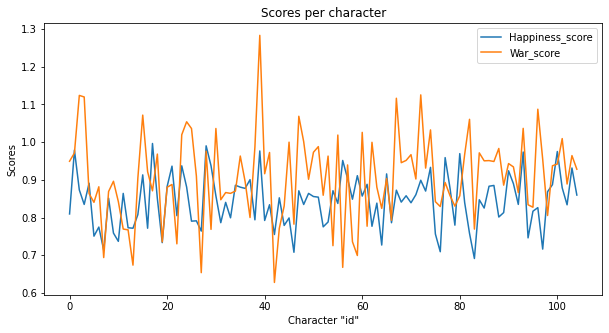

In [48]:
scores_list.plot()
plt.title('Scores per character')
plt.xlabel('Character \"id\"')
plt.ylabel('Scores')
plt.show()

In [49]:
# Save to CSV
scores_list.to_csv("characters_scores.csv", sep=';', index=False)

We can see now that the war score is more expanded than the happiness score. It makes sense as some characters are great fighters, and other are just scientists, or civilians.

## Movie sentiment analysis

For the movie sentiment analysis, we look at the average happiness score of the words in the movie plot.

In [50]:
def get_movie_happiness(name):

    with open("movie_plots/" + name, "r", encoding="utf-8") as text_file:
        content = text_file.read()

        # Tokenize, Remove punctuation and lemmatize
        tokenized = nltk.WordPunctTokenizer.tokenize(nltk.WordPunctTokenizer(), content)
        tokenized = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokenized]
        tokenized = [w.lower() for w in tokenized]
        lemmatized = [nltk.WordNetLemmatizer.lemmatize(nltk.WordNetLemmatizer(), w) for w in tokenized]
        lemmatized = [w for w in lemmatized if len(w) > 3]

        # Calculating score for each word
        score_list = []

        for word in lemmatized:
            score = get_score(word)
            if (score >= 0):
                score_list.append(score)
    
        if (len(score_list) > 0):
            final_score = sum(score_list)/len(score_list)
        else:
            final_score = 0

    return final_score

In [51]:
from os import listdir
from os.path import isfile, join

movies_happiness_list = pd.DataFrame(columns=['Name', 'Happiness_score'])

onlyfiles = [f for f in listdir("movie_plots/") if isfile(join("movie_plots/", f))]
for file in onlyfiles:
    score = get_movie_happiness(file)
    if (score > 0):
        movies_happiness_list = movies_happiness_list.append({'Name': file.replace(".txt", "").replace("_", " "), 'Happiness_score': score}, ignore_index=True)

In [52]:
print("Saddest movies\n\n", movies_happiness_list.sort_values(by=['Happiness_score'], ascending=[True])[0:10])

Saddest movies

                               Name  Happiness_score
5                     The Avengers         3.302823
19           Captain Marvel (film)         3.362094
6   Guardians of the Galaxy (film)         3.441965
23            Black Panther (film)         3.487932
12                  Thor: Ragnarok         3.569477
3             Thor: The Dark World         3.571386
0          Avengers: Age of Ultron         3.586730
1   Guardians of the Galaxy Vol. 2         3.603692
21                      Iron Man 3         3.626606
9           Avengers: Infinity War         3.644558


In [53]:
print("Happiest movies\n\n", movies_happiness_list.sort_values(by=['Happiness_score'], ascending=[False])[0:10])

Happiest movies

                                    Name  Happiness_score
14                 Ant-Man and the Wasp         4.595849
20   Captain America: The First Avenger         4.332814
2                   The Incredible Hulk         4.295531
18  Captain America: The Winter Soldier         4.276719
4                 Doctor Strange (film)         4.080890
22               Spider-Man: Homecoming         4.042371
17                    Avengers: Endgame         4.021257
15           Captain America: Civil War         4.019761
7                        Ant-Man (film)         3.989181
10            Spider-Man: Far From Home         3.913727


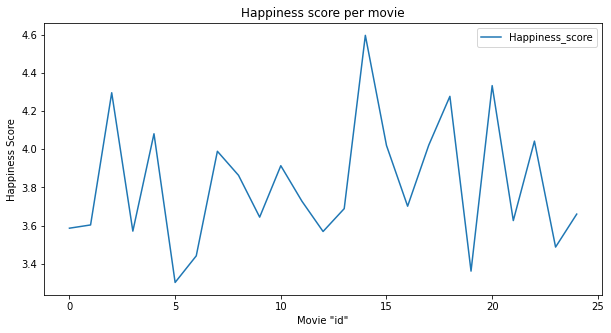

In [54]:
movies_happiness_list.plot()
plt.title('Happiness score per movie')
plt.xlabel('Movie \"id\"')
plt.ylabel('Happiness Score')
plt.show()

We can't really conclude something about the sentiment analysis of movies. This is not really surprising considering that all marvel movies are quite similar in their plots.

## Community sentiment analysis

Now that we are more precise about the sentiments of characters, we can look at the sentiment of communities. We took the most important characters of each communities, and then calculated the average happiness score and war score.

In [55]:
# Get Data
scores_list = pd.read_csv('characters_scores.csv', names=['Name', 'Happiness_score', 'War_score'], sep=';', header=0)
community_list = pd.read_csv('community.csv', names=['Name', 'Community'], header=0)

In [56]:
community_scores = pd.DataFrame(columns=['Community', 'Happiness_score', 'War_score'])

# Calculate averages scores per community characters
for community_id in set(community_list['Community']):
    happiness_scores = []
    war_scores = []

    print('\nCommunity ID : ', community_id, '\n')

    for name, h, w in scores_list.values:
        name = name.replace(' ', '_')
        try:
            community = community_list[community_list['Name']==name]['Community'].values[0]
            if (community == community_id):
                print(name)
                happiness_scores.append(h)
                war_scores.append(w)
        except:
            community = -1
    
    h_score = 0
    w_score = 0

    if (len(happiness_scores) > 0):
        h_score = sum(happiness_scores)/len(happiness_scores)
    
    if (len(war_scores) > 0):
        w_score = sum(war_scores)/len(war_scores)
    
    if (len(happiness_scores) > 0 or len(war_scores) > 0):
        community_scores = community_scores.append({'Community': community_id, 'Happiness_score': h_score, 'War_score': w_score}, ignore_index=True)
    


    


Community ID :  0 

Baron_Zemo
Black_Panther
Erik_Killmonger
Everett_Ross
Nakia
Okoye
Shuri
T'Chaka
Ulysses_Klaue
W'Kabi

Community ID :  1 

Flash_Thompson
May_Parker
Michelle_Jones
Ned_Leeds
Shocker
Spider-Man
Vulture

Community ID :  2 

Captain_Marvel
Talos
Yon-Rogg

Community ID :  3 

Ajak
Gilgamesh
Ikaris

Community ID :  4 

Darcy_Lewis
Ebony_Maw
Executioner
Fandral
Frigga
Grandmaster
Heimdall
Hela
Hogun
Hulk
Jane_Foster
Loki
Malekith
Proxima_Midnight
Sif
Thanos
Thor
Valkyrie
Volstagg

Community ID :  5 

Ant-Man
Bill_Foster
Ghost
Hank_Pym
Janet_van_Dyne
Jim_Paxton
Jimmy_Woo
Luis
Wasp
Yellowjacket

Community ID :  6 

Ancient_One
Christine_Palmer
Doctor_Strange
Kaecilius
Karl_Mordo
Wong

Community ID :  7 

Abomination
Alexander_Pierce
Black_Widow
Captain_America
Georges_Batroc
Gideon_Malick
Hawkeye
Jasper_Sitwell
Maria_Hill
Nick_Fury
Phil_Coulson
Quicksilver
Red_Guardian
Scarlet_Witch
Sharon_Carter
Taskmaster
Thaddeus_Ross
Ultron
Vision
Yelena_Belova

Community ID :  8 

Drax

In [57]:
print("Communities by war score\n\n", community_scores.sort_values(by=['War_score'], ascending=[False])[0:10])

Communities by war score

     Community  Happiness_score  War_score
3         3.0         0.981938   1.076903
8         8.0         0.885134   0.971283
9         9.0         0.867232   0.954432
7         7.0         0.806817   0.920249
4         4.0         0.852485   0.903325
6         6.0         0.840968   0.901803
2         2.0         0.878515   0.900321
10       10.0         0.795802   0.886476
0         0.0         0.866301   0.880459
5         5.0         0.782711   0.842073


In [58]:
print("Communities by happiness score\n\n", community_scores.sort_values(by=['Happiness_score'], ascending=[False])[0:10])

Communities by happiness score

     Community  Happiness_score  War_score
3         3.0         0.981938   1.076903
8         8.0         0.885134   0.971283
2         2.0         0.878515   0.900321
9         9.0         0.867232   0.954432
0         0.0         0.866301   0.880459
4         4.0         0.852485   0.903325
6         6.0         0.840968   0.901803
1         1.0         0.831035   0.776647
7         7.0         0.806817   0.920249
10       10.0         0.795802   0.886476


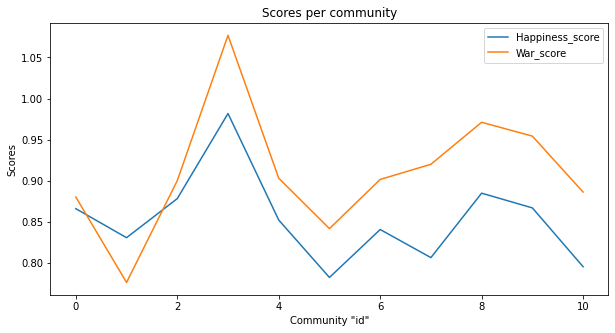

In [59]:
community_scores.plot(x='Community')
plt.title('Scores per community')
plt.xlabel('Community \"id\"')
plt.ylabel('Scores')
plt.show()

The first thing we can see is that the two curves seem related, even though they are not based on the same words. This means that some communities are more intense in their feeling than others. For example, the Guardians of the Galaxy and Shang Xi communities are more intense than the Ant-Man community (which movies are lighter).

Another interesting thing to notice is that there is only one community that has a happiness score higher than his war score, and that's the Spider-Man community ! It makes sens as these movies feature a lot of teenagers characters.

# V. Discussion

Community detection found communities related to movie series, however a community belonging to a movie series does not necessarily contain the main character of that movie series. Marvel likes to mix main characters in movies, and has done a movie series called The Avengers where many main characters appear. This can explain the lack of main characters in the community related to the movie series, which they are the main character in. 

Sentiment analysis seemed to be quite difficult to discuss, mainly for movie storylines. the scores found were always quite close to each other, and the sentiment score assigned to a word cannot always be linked to happiness. However, we did manage to use it for characters and communities, and the War Score we got was relevant to most chatacters. For further research, we could try a different bank of word for the sentiment analysis, and compare it with what we found with LabMT.

# VI. Contributions

Every member of the team did an amazing job, and the team performed really well :)

To go more into details:
- **Rune** worked on the community detection, with the help of Paris.
- **Julien** has done the sentiment analysis of characters and movie plots, aswell as the sentiment of communities.
- **Paris** was in charge of downloading and cleaning the data of characters and movies, making the graph with the help of Rune, and building the website.

Each team member provided assistance to all the parts of the notebook.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ff242c93-7fd5-4860-b5a9-fe8b9fab96e0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>